In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
plt.style.use('seaborn-v0_8-paper')
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.dpi']=150
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

1. Generate random Gaussian numbers, with mean 0 and std 1. Using the Box Muller algorithm

In [3]:
# The first step is to generate two uniform random numbers
def box_muller():
    u1 = np.random.rand()
    u2 = np.random.rand()

    # Now we can use the Box-Muller transform to get two independent standard normal random variables
    z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
    z1 = np.sqrt(-2.0 * np.log(u1)) * np.sin(2.0 * np.pi * u2)

    return z0, z1

# Function to generate n_samples Gaussian random numbers
def generate_gaussian_samples(n_samples):
    samples = []
    for _ in range(n_samples // 2):  # Generate pairs of samples
        z0, z1 = box_muller()
        samples.extend([z0, z1])
    if n_samples % 2 == 1:  # If odd number of samples, generate one more
        z0, _ = box_muller()
        samples.append(z0)
    return np.array(samples)

# Function to compute the Gaussian PDF
def gaussian_pdf(x):
    return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

In [4]:
# Generate samples
n_samples = 10000
samples = generate_gaussian_samples(n_samples)

# Compute the mean and standard deviation of the generated samples
mean = np.mean(samples)
std_dev = np.std(samples)

print(f'Mean: {mean:4f}, Standard Deviation: {std_dev:4f}')

Mean: -0.010893, Standard Deviation: 0.989583


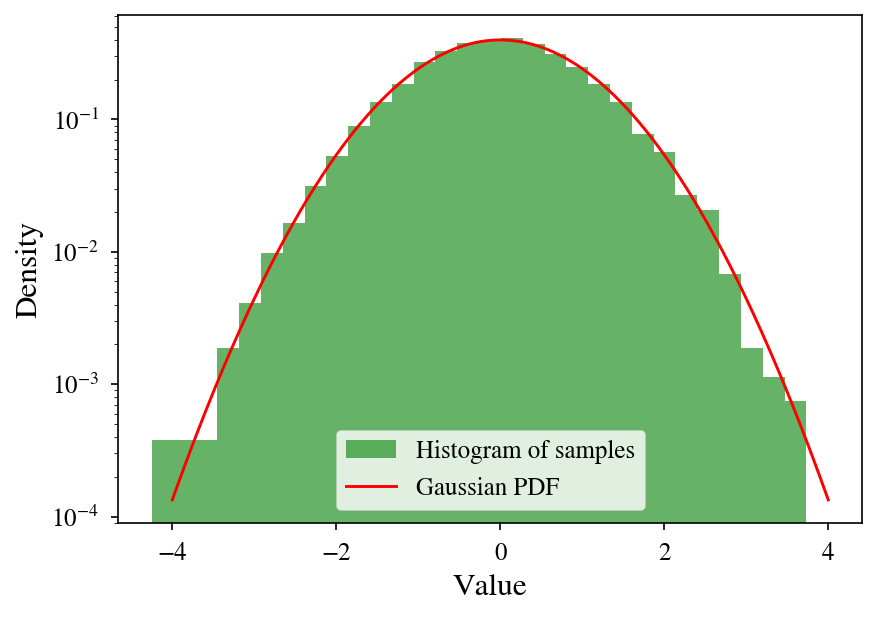

In [5]:
# Generate a histogram of the generated samples
x=np.linspace(-4, 4, 1000)
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g', label='Histogram of samples')
plt.plot(x, gaussian_pdf(x), label='Gaussian PDF', color='r')
plt.yscale('log')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

2. Now we will use this Gaussian numbers to simulate the trajectory of a particle in an open box, following the equations:

$$x_i(t+\delta_t)= x_i(t) + \frac{g^x_i}{\gamma}\sqrt{2\Gamma\delta_t}$$
$$y_i(t+\delta_t)= y_i(t) + \frac{g^y_i}{\gamma}\sqrt{2\Gamma\delta_t}$$

With $\gamma$=1, and we will plot until time $\tau=100\delta_t$.

In [6]:
# Create the trajectory simulation functions
def next_position(x, y, g_x, g_y, delta_t, gamma, Gamma):
    x_new = x + (g_x / gamma) * np.sqrt(2 * Gamma * delta_t)
    y_new = y + (g_y / gamma) * np.sqrt(2 * Gamma * delta_t)
    return x_new, y_new

def simulate_trajectory(n_steps, delta_t, x_0=0, y_0=0, gamma=1, Gamma=1):
    trajectory = np.zeros((n_steps, 2))
    trajectory[0] = [x_0, y_0]
    
    for t in range(1, n_steps):
        g_x, g_y = box_muller()  # Generate new Gaussian random numbers for each step
        x_new, y_new = next_position(trajectory[t-1, 0], trajectory[t-1, 1], g_x, g_y, delta_t, gamma, Gamma)
        trajectory[t] = [x_new, y_new]
    
    return trajectory

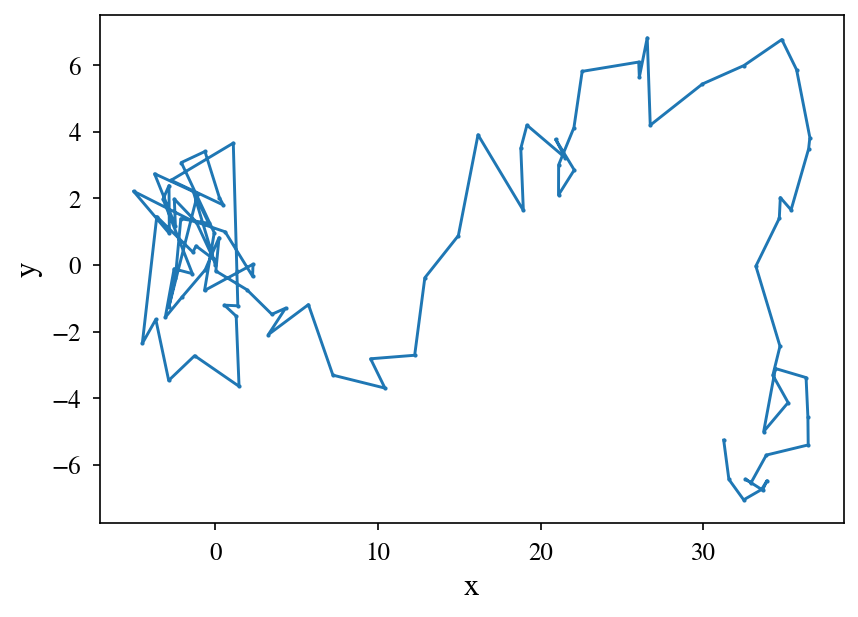

In [7]:
# Define parameters for the simulation
delta_t = 1
n_steps = 100  # Simulate until time tau = 100 * delta_t

# Simulate the trajectory
trajectory = simulate_trajectory(n_steps, delta_t)

# Plot the trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', markersize=2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

3. Now we implement periodic boundary conditions, as the particles are in an $L\times L$ box with $L=100$. We will simulate multiple trajectories and plot the initial and final positions.

In [8]:
def simulate_pbc(n_steps, delta_t, L, gamma=1, Gamma=1):
    trajectory = np.zeros((n_steps, 2))
    x_0, y_0 = np.random.uniform(0, L, size=2)  # Random initial position within the box    
    trajectory[0] = [x_0, y_0]  # Apply periodic boundary conditions at the start
    
    for t in range(1, n_steps):
        g_x, g_y = box_muller()  # Generate new Gaussian random numbers for each step
        x_new, y_new = next_position(trajectory[t-1, 0], trajectory[t-1, 1], g_x, g_y, delta_t, gamma, Gamma)
        trajectory[t] = [x_new % L, y_new % L]  # Apply periodic boundary conditions
    
    return trajectory

def sim_multiple_trajectories(n_traj, n_steps, delta_t, L, gamma=1, Gamma=1):
    trajectories = []
    for _ in range(n_traj):
        traj = simulate_pbc(n_steps, delta_t, L, gamma, Gamma)
        trajectories.append(traj)
    return trajectories

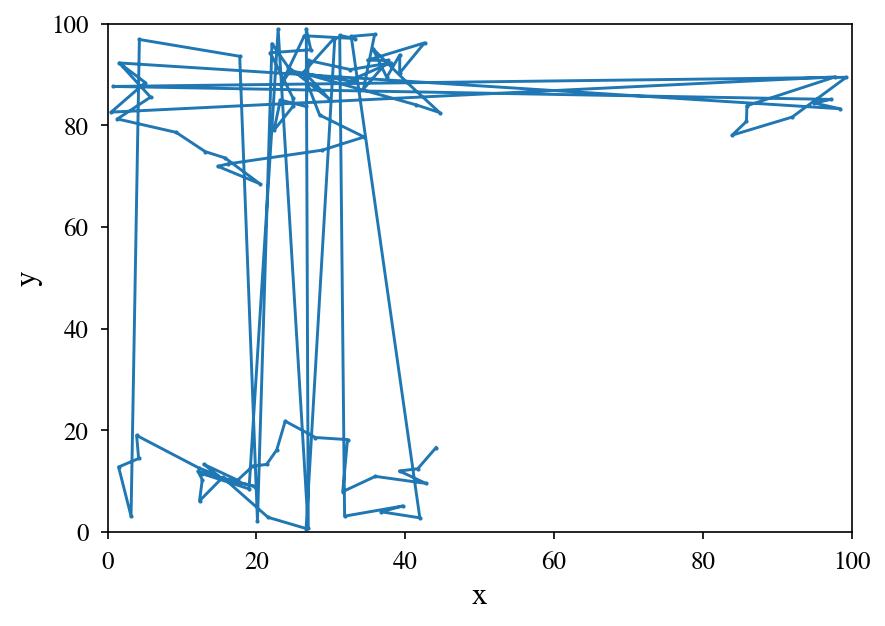

In [9]:
# Plot one trajectory with PBC
L = 100
delta_t = 10
n_steps = 100   # Simulate until time tau = 100 * delta_t

trajectory_pbc = simulate_pbc(n_steps, delta_t, L)
plt.plot(trajectory_pbc[:, 0], trajectory_pbc[:, 1], marker='o', markersize=2)
plt.xlim(0, L)
plt.ylim(0, L)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We see that with this $\delta_t$ the random walk explores a large amount of the space.

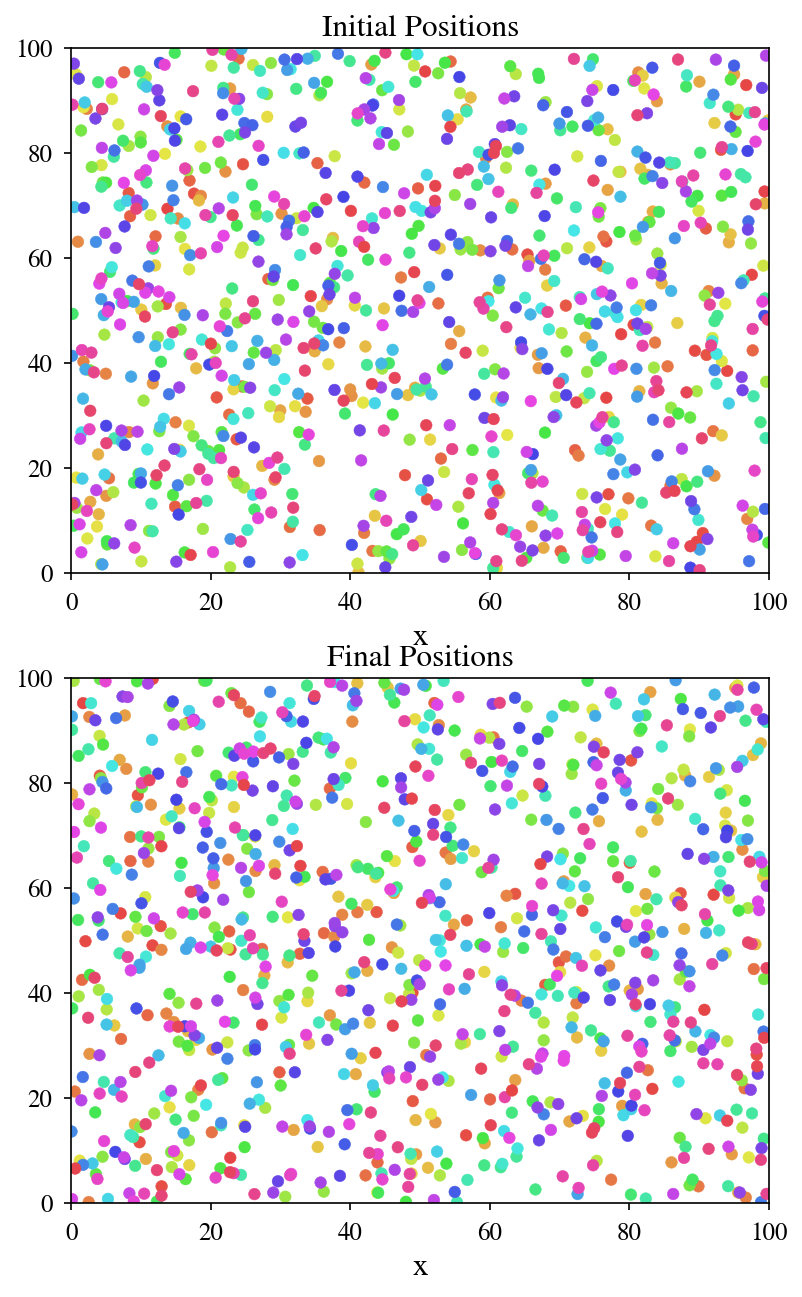

In [18]:
from matplotlib.colors import hsv_to_rgb
# Define parameters for the simulation
delta_t = 1
L = 100
n_steps = 100  # Simulate until time tau = 100 * delta_t
n_traj =  1000 # Number of trajectories to simulate

# Simulate the trajectories
trajectories = sim_multiple_trajectories(n_traj, n_steps, delta_t, L)

colors = [hsv_to_rgb([i / n_traj, 0.7, 0.9]) for i in range(n_traj)]

initial_positions = [traj[0] for traj in trajectories]
x_0, y_0 = zip(*initial_positions)

final_positions = [traj[-1] for traj in trajectories]
x_f, y_f = zip(*final_positions)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
ax[0].scatter(x_0, y_0, marker='o', color=colors)
ax[0].set_xlim(0, L)
ax[0].set_ylim(0, L)
ax[0].set_title('Initial Positions')
ax[0].set_xlabel('x')   

ax[1].scatter(x_f, y_f, marker='o', color=colors)
ax[1].set_xlim(0, L)
ax[1].set_ylim(0, L)
ax[1].set_title('Final Positions')
ax[1].set_xlabel('x')   
plt.show()



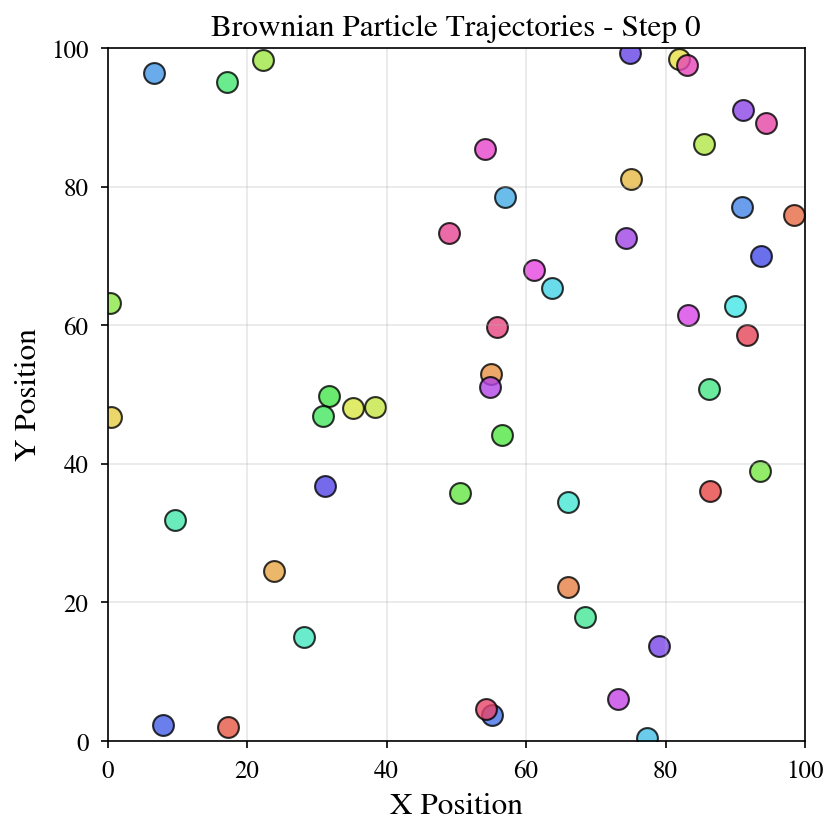

In [21]:
from matplotlib.animation import FuncAnimation
from matplotlib.colors import hsv_to_rgb

# Define parameters for the simulation
delta_t = 1
L = 100
n_steps = 100
n_particles = 50

# Simulate the trajectories
trajectories = sim_multiple_trajectories(n_particles, n_steps, delta_t, L)

# Simpler version - just update, no fancy optimization
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Brownian Particle Trajectories')
ax.grid(True, alpha=0.3)

colors = [hsv_to_rgb([i / n_particles, 0.7, 0.9]) for i in range(n_particles)]

def animate(frame):
    ax.clear()
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'Brownian Particle Trajectories - Step {frame}')
    ax.grid(True, alpha=0.3)
    
    for i, traj in enumerate(trajectories):
        # Plot trail
        ax.plot(traj[:frame+1, 0], traj[:frame+1, 1], '-', 
                color=colors[i], alpha=0.3, linewidth=1)
        # Plot current position
        ax.scatter(traj[frame, 0], traj[frame, 1], s=100, 
                  color=colors[i], alpha=0.8, edgecolors='black', linewidths=1)

anim = FuncAnimation(fig, animate, frames=n_steps, interval=200, repeat=True)

# For Jupyter notebooks, use this:
# HTML(anim.to_jshtml())
anim.save('brownian_particles.gif', writer='pillow', fps=5)

4. Compute the Mean-Square Displacement (MSD) averaged over $N$ with

$$\Delta^2(t)=N^{-1}\sum^N_{i=1}\langle(\bf{r}_i(t)-\bf{r}(0))^2\rangle$$

for $\Gamma = 0.1, 1, 3, 10, 30, ...$ Calculate also the relationship between $\Gamma$ and the diffusivity $D$, defined as

$$D = \lim_{t\to \infty} \frac{\Delta^2(t)}{4t}$$

In [22]:
# To calculate the MSD, we refrain from using periodic boundary conditions

def compute_msd(Gamma, n_steps, N):
    trajectories = []
    for _ in range(N):
        traj = simulate_trajectory(n_steps, delta_t=1, Gamma=Gamma)
        trajectories.append(traj)
    n_traj = N
    msd = np.zeros(n_steps)
    
    for traj in trajectories:
        displacements = traj - traj[0]  # Displacement from initial position
        squared_displacements = np.sum(displacements**2, axis=1)  # Squared displacement
        msd += squared_displacements
    
    msd /= n_traj  # Average over all trajectories
    return msd

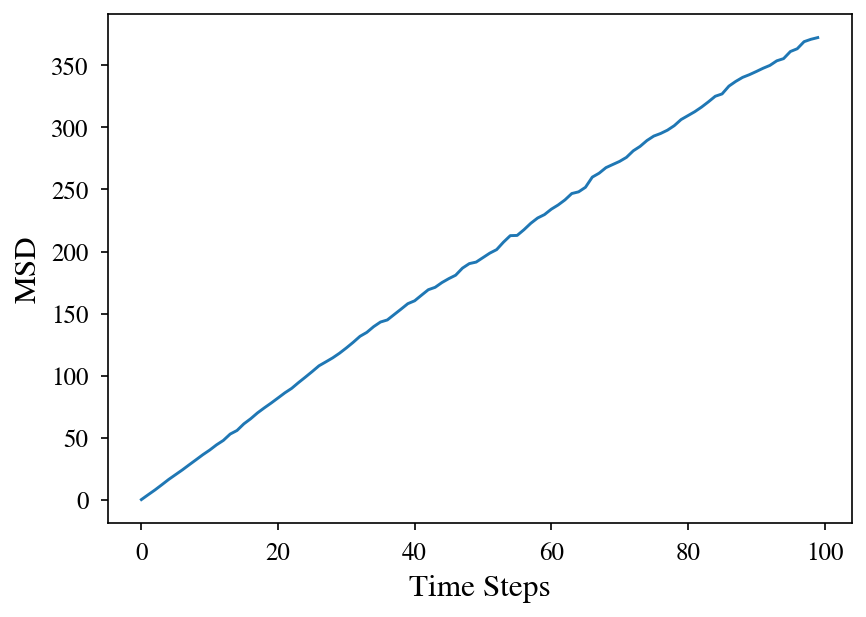

In [23]:
MSD = compute_msd(Gamma=1, n_steps=100, N=1000)
plt.plot(MSD)
plt.xlabel('Time Steps')
plt.ylabel('MSD')   
plt.show()

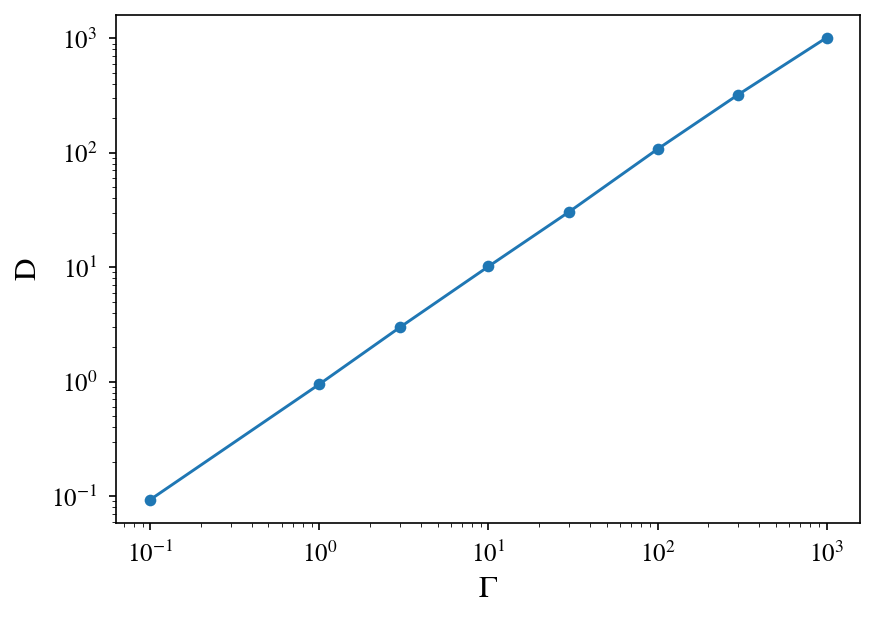

[0.1, 1, 3, 10, 30, 100, 300, 1000] [0.09314541899323035, 0.9501866990118513, 2.98816442618773, 10.148748388835259, 30.473352494178016, 107.55322434896583, 321.94528834464063, 1013.1346223633432]


In [26]:
# Now we want to compute the diffusion coefficient for different values of Gamma
Gammas = [0.1, 1, 3, 10, 30, 100, 300, 1000]

diffusion_coeffs = []
for Gamma in Gammas:
    MSD = compute_msd(Gamma=Gamma, n_steps=100, N=1000)
    # Fit a line to the MSD data to extract the diffusion coefficient
    time_steps = np.arange(len(MSD))
    coeffs = np.polyfit(time_steps, MSD, 1)  # Linear fit
    D = coeffs[0] / 4  # D = slope / 4 in 2D
    diffusion_coeffs.append(D)
    
# Plot the diffusion coefficient vs Gamma
plt.loglog(Gammas, diffusion_coeffs, marker='o')
plt.xlabel('$\Gamma$')
plt.ylabel('D')
plt.show()
print(Gammas,diffusion_coeffs)